In [1]:
import matplotlib.pyplot as plt # For general plotting
import matplotlib.colors as mcol

import numpy as np

from scipy.stats import multivariate_normal as mvn
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import KFold # Important new include

import torch
import torch.nn as nn
import torch.nn.functional as F
# Utility to visualize PyTorch network and shapes
from torchsummary import summary

np.set_printoptions(suppress=True)

# Set seed to generate reproducible "pseudo-randomness" (handles scipy's "randomness" too)


plt.rc('font', size=22)          # controls default text sizes
plt.rc('axes', titlesize=18)     # fontsize of the axes title
plt.rc('axes', labelsize=18)     # fontsize of the x and y labels
plt.rc('xtick', labelsize=14)    # fontsize of the tick labels
plt.rc('ytick', labelsize=14)    # fontsize of the tick labels
plt.rc('legend', fontsize=16)    # legend fontsize
plt.rc('figure', titlesize=22)   # fontsize of the figure title


In [2]:
def MAP_gamma(X,y,gamma):
    theta = np.linalg.inv(X.T.dot(X)).dot(X.T.dot(y))
    return theta

def batchify(X, y, batch_size, N):
    X_batch = []
    y_batch = []

    # Iterate over N in batch_size steps, last batch may be < batch_size
    for i in range(0, N, batch_size):
        nxt = min(i + batch_size, N + 1)
        X_batch.append(X[i:nxt, :])
        y_batch.append(y[i:nxt])

    return X_batch, y_batch

def gradient_descent(loss_func, theta0, X, y, N, beta, *args, **kwargs):
    # Mini-batch GD. Stochastic GD if batch_size=1.

    # Break up data into batches and work out gradient for each batch
    # Move parameters theta in that direction, scaled by the step size.

    # Options for total sweeps over data (max_epochs),
    # and parameters, like learning rate and threshold.

    # Default options
    max_epoch = kwargs['max_epoch'] if 'max_epoch' in kwargs else 200
    alpha = kwargs['alpha'] if 'alpha' in kwargs else 0.1
    epsilon = kwargs['tolerance'] if 'tolerance' in kwargs else 1e-6

    batch_size = kwargs['batch_size'] if 'batch_size' in kwargs else 10

    # Turn the data into batches
    X_batch, y_batch = batchify(X, y, batch_size, N)
    num_batches = len(y_batch)
    print("%d batches of size %d:" % (num_batches, batch_size))

    theta = theta0
    m_t = np.zeros(theta.shape)

    trace = {}
    trace['loss'] = []
    trace['theta'] = []

    # Main loop:
    for epoch in range(1, max_epoch + 1):
        # print("epoch %d\n" % epoch)
        
        loss_epoch = 0
        for b in range(num_batches):
            X_b = X_batch[b]
            y_b = y_batch[b]
            # print("epoch %d batch %d\n" % (epoch, b))

            # Compute NLL loss and gradient of NLL function
            loss, gradient = loss_func(theta, X_b, y_b, beta, *args)
            loss_epoch += loss
            
            # Steepest descent update
            theta = theta - alpha * gradient
            
            # Terminating Condition is based on how close we are to minimum (gradient = 0)
            if np.linalg.norm(gradient) < epsilon:
                print("Gradient Descent has converged after {} epochs".format(epoch))
                break
        # Storing the history of the parameters and loss values per epoch
        trace['loss'].append(np.mean(loss_epoch))
        trace['theta'].append(theta)
        # print(trace['loss'])
        # Also break epochs loop
        if np.linalg.norm(gradient) < epsilon:
            break

    return theta, trace

def lin_reg_loss(theta, X, y, beta):
    # Size of batch
    B = X.shape[0]
    # Linear regression model X * theta
    predictions = X.dot(theta)
    # Residual error (X * theta) - y
    error = predictions - y
    # Loss function is MSE
    # print(error)
    # loss_f = np.mean(error ** 2)

    # loss_f = 0.5*error.T.dot(error)
#     loss_f = (X.dot(theta)-y).T.dot(X.dot(theta)-y)
    loss_f = (X.dot(theta)-y).T.dot(X.dot(theta)-y) + beta*(theta.dot(theta))

    # print(loss_f)
    # Partial derivative for GD, X^T * ((X * theta) - y)
    g = (1 / B) * X.T.dot(error)
    # g = (X.T.dot(error) - X.T.dot(y))

    return loss_f, g

def mean_square_err(X,y,theta):
    y_predict = X.dot(theta) #+ noiseV
    ### MSE
    mse = np.mean((y - y_predict)**2)
    return mse

def MAP_gamma(X,y,gamma):
    theta = np.linalg.inv(X.T.dot(X)+gamma*np.identity(X.shape[1])).dot(X.T.dot(y))
    return theta


def mle_solution(X, y):
    # Model: y = phi(X)^T*theta
    # LS estimate: theta^* = (phi(X)^T*phi(X))^-1 * phi(X)^T * y 
    return np.linalg.inv(X.T.dot(X)).dot(X.T).dot(y)

def cross_validation(X,y,betas):
    # Number of folds for CV
    K = 5

    # STEP 1: Partition the dataset into K approximately-equal-sized partitions
    # Shuffles data before doing the division into folds (not necessary, but a good idea)
    kf = KFold(n_splits=K, shuffle=True) 
    n_betas = len(betas)

    # Allocate space for CV
    # No need for training loss storage too but useful comparison
    mse_valid_mk = np.empty((n_betas, K)) 
    mse_train_mk = np.empty((n_betas, K)) # Indexed by model m, data partition k

    # STEP 2: Try all polynomial orders between 1 (best line fit) and 21 (big time overfit) M=2
    i=0
    for beta in betas:
        # K-fold cross validation
        k = 0
        # NOTE that these subsets are of the TRAINING dataset
        # Imagine we don't have enough data available to afford another entirely separate validation set
        for train_indices, valid_indices in kf.split(X):
            # Extract the training and validation sets from the K-fold split
            X_train_k = X[train_indices]
            y_train_k = y[train_indices]
            X_valid_k = X[valid_indices]
            y_valid_k = y[valid_indices]

            # Train model parameters
            w_map = MAP_beta(X_train_k,y_train_k,beta)
#             w_map = mle_solution(X_train_k,y_train_k)
            
            mse_train_mk[i, k] = mean_square_err(X_train_k, y_train_k,w_map)
            mse_valid_mk[i, k] = mean_square_err(X_valid_k, y_valid_k,w_map)
            
#             # Make predictions on both the training and validation set
#             y_train_k_pred = X_train_k_poly.dot(theta_mk)        
#             y_valid_k_pred = X_valid_k_poly.dot(theta_mk)   
            
#             # Record MSE as well for this model and k-fold
#             mse_train_mk[deg - 1, k] = mean_square_err(y_train_k_pred, y_train_k)
#             mse_valid_mk[deg - 1, k] = mean_square_err(y_valid_k_pred, y_valid_k)
            
            k += 1            
        i += 1
#     print(mse_train_mk)
    
    # STEP 3: Compute the average MSE loss for that model (based in this case on degree d)
    mse_train_m = np.mean(mse_train_mk, axis=1) # Model average CV loss over folds
    mse_valid_m = np.mean(mse_valid_mk, axis=1) 

    # +1 as the index starts from 0 while the degrees start from 1
    optimal_beta_ind = np.argmin(mse_valid_m)
    optimal_beta = betas[optimal_beta_ind]
#     print("The model selected to best fit the data without overfitting is: beta = {}".format(optimal_beta))
    return optimal_beta,mse_valid_m

def MAP_beta(Xaug,y,beta):
    theta = np.linalg.inv(Xaug.T.dot(Xaug)+beta*np.identity(Xaug.shape[1])).dot(Xaug.T.dot(y))
    return theta

mse of beta: 7.987717400527491
optimal beta: 1


C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)


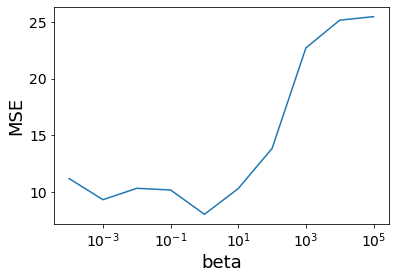

In [23]:
# Generate all Data
np.random.seed(7)
torch.manual_seed(7)

n = 10
Ntrain = 50
Ntest = 100


xTrain = np.zeros((Ntrain,n))
zTrain = np.zeros((Ntrain,n))
yTrain = np.zeros(Ntrain)

xTest = np.zeros((Ntest,n))
zTest = np.zeros((Ntest,n))
yTest = np.zeros(Ntest)

a_vect = np.random.randn(n)
mu = np.random.randn(n)
Sigma = abs(np.random.randn(n,n))

z_vect = np.random.randn(n)
alpha = abs(np.random.randn())
sig_z = np.identity(n)*alpha
mu_z = np.zeros(n)

# v = np.random.randn()

for i in range(Ntrain):
    xTrain[i,:] = mvn.rvs(mu,Sigma)
    zTrain[i,:] = mvn.rvs(mu_z,sig_z)
    yTrain[i] = a_vect.T.dot(xTrain[i]+zTrain[i]) + np.random.randn() #+ v



for i in range(Ntest):
    xTest[i,:] = mvn.rvs(mu,Sigma)
    zTest[i,:] = mvn.rvs(mu_z,sig_z)
    yTest[i] = a_vect.T.dot(xTest[i]+zTest[i]) + np.random.randn() #+ v


w_0 = np.zeros(n+1)
xTrainAug = np.column_stack((np.ones(Ntrain), xTrain))
xTestAug = np.column_stack((np.ones(Ntest), xTest))

np.random.seed(7)
betas = [10**i for i in range(-4,6)]
# betas = np.linspace(.0001,10000,10000)

opt_beta, mse_beta = cross_validation(xTrain,yTrain,betas)
print('mse of beta:',min(mse_beta))
print('optimal beta:',opt_beta)
plt.plot(betas,mse_beta)
plt.xscale('log')
plt.xlabel('beta')
plt.ylabel('MSE')
plt.show()

[   0.0018774     0.00215856    0.00248182    0.00285348    0.00328081
    0.00377214    0.00433704    0.00498655    0.00573332    0.00659192
    0.00757911    0.00871413    0.01001913    0.01151957    0.0132447
    0.01522819    0.01750872    0.02013077    0.02314549    0.02661169
    0.03059698    0.03517909    0.04044741    0.04650469    0.05346909
    0.06147646    0.07068299    0.08126827    0.09343876    0.10743186
    0.12352054    0.1420186     0.16328688    0.18774023    0.21585565
    0.24818154    0.28534846    0.32808139    0.37721387    0.43370429
    0.49865454    0.57333155    0.65919196    0.75791056    0.87141297
    1.00191316    1.15195667    1.32447024    1.52281892    1.7508717
    2.01307699    2.31454935    2.66116931    3.05969803    3.51790921
    4.04474073    4.65046894    5.3469092     6.14764626    7.06829929
    8.12682655    9.34387568   10.74318643   12.35205375   14.20186021
   16.32868812   18.77402339   21.58556473   24.81815404   28.53484622
   32.80

C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packag

C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packag

C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packages\scipy\stats\_multivariate.py:664: RuntimeWarning: covariance is not positive-semidefinite.
  out = random_state.multivariate_normal(mean, cov, size)
C:\Users\tceri\Anaconda3\lib\site-packag

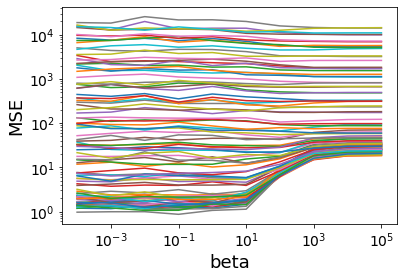

In [21]:
np.random.seed(7)

n = 10
Ntrain = 50
Ntest = 100


xTrain = np.zeros((Ntrain,n))
zTrain = np.zeros((Ntrain,n))
yTrain = np.zeros(Ntrain)

xTest = np.zeros((Ntest,n))
zTest = np.zeros((Ntest,n))
yTest = np.zeros(Ntest)

a_vect = np.random.randn(n)
mu = np.random.randn(n)
Sigma = abs(np.random.randn(n,n))+np.identity(n)

# alphas = np.arange(.001*np.trace(Sigma)/n,1000*np.trace(Sigma)/n,5)
alphas = np.geomspace(.001*np.trace(Sigma)/n,1000*np.trace(Sigma)/n,100)
print(alphas)
for alpha in alphas:
    sig_z = np.identity(n)*alpha
    mu_z = np.zeros(n)

    # v = np.random.randn()

    for i in range(Ntrain):
        xTrain[i,:] = mvn.rvs(mu,Sigma)
        zTrain[i,:] = mvn.rvs(mu_z,sig_z)
        yTrain[i] = a_vect.T.dot(xTrain[i]+zTrain[i]) + np.random.randn() #+ v



    for i in range(Ntest):
        xTest[i,:] = mvn.rvs(mu,Sigma)
        zTest[i,:] = mvn.rvs(mu_z,sig_z)
        yTest[i] = a_vect.T.dot(xTest[i]+zTest[i]) + np.random.randn() #+ v


    w_0 = np.zeros(n+1)
    xTrainAug = np.column_stack((np.ones(Ntrain), xTrain))
    xTestAug = np.column_stack((np.ones(Ntest), xTest))

    betas = [10**i for i in range(-4,6)]
    # betas = np.linspace(.0001,10000,10000)
    mse_beta = 0
    opt_beta, mse_beta = cross_validation(xTrain,yTrain,betas)
#     print('mse of beta:',min(mse_beta))
    plt.plot(betas,mse_beta)
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('beta')
    plt.ylabel('MSE')
plt.show()

In [20]:
# print(alphas)

[1.5 1.5 1.5 1.5]
